In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# from train_test_split import train_test_split_hoc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import tensorflow as tf

In [24]:
# if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
#     raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks.parquet")

In [25]:
%run "train_test_split_sampled.ipynb"
df_sampled = sampling(df)

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>
<div style="text-align: justify">Experiment language models for solving the same supervised task as in Section 2. In this task, the objective is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign intents to sessions). 
<br><br> Two interesting concepts play a role when we use neural networks:
<div style="text-align: justify"><br><b>1)</b> It is possible to do transfer learning, i.e., to take a model that have been trained with other enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model starting from its pre-trained version.
<br><b>2)</b> In NLP tasks, words/documents are transformed into vectors (encoding) and this task is Unsupervised, so we can use a much larger amount of data.
</div><br>
<div style="text-align: justify"><b>4.1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)</div><b>
<br><left><b><font size=3> Data Preparation and Cleaning </div></b>
<br><left><b><font size=2> Step 1 </div></b>
The initial phase involved loading the dataset from the 'ssh_attacks.parquet' file. To ensure data quality, a cleaning process was implemented on the 'full_session' column. Non-alphabetic characters were filtered out, and the text was converted to lowercase. This cleaning process was crucial for creating a meaningful representation of the session data.

In this endeavor, we embark on a journey to construct a robust Session Intent Classification model with the overarching goal of assigning intents to sessions using state-of-the-art techniques, specifically leveraging the Doc2Vec model and TensorFlow.

Our odyssey begins with the exploration of a dataset encapsulating session data, with the central task being the classification of intents. We harness the power of the Pandas library to load our dataset from a parquet file, granting us a glimpse into the raw data's structure.


A critical facet of our journey involves preparing the textual data for model ingestion. Employing a function to clean the text, we filter out non-alphabetic characters and convert the text to lowercase, ensuring uniformity and aiding in subsequent analysis.

Subsequently, we embark on the tokenization journey, a crucial step where we convert the cleaned sessions into tagged documents. This allows us to represent our textual data in a format suitable for training the Doc2Vec model.

In [26]:
tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

##### Building and Training Doc2Vec Model

<div style="text-align: justify">{Cleaning the text data by removing non-alphabetic characters and converting text to lowercase. The Gensim library was used to train a Doc2Vec model on the cleaned text data. A vocabulary was buildt and the Doc2Vec model was trained to generate the vector of embeddings for each session text.}</div>

Our expedition proceeds with the training of the Doc2Vec model, an unsupervised learning algorithm designed to transform words or documents into numerical vectors. Configuring the model with specific parameters, such as vector size, window size, and epochs, we meticulously craft a representation of the textual data.

In [27]:
'''
if not os.path.isfile("trained_doc2vec_model.model"):
    doc2vec_model = Doc2Vec(tagged_data)
    #doc2vec_model.build_vocab(tagged_data)
    #doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    doc2vec_model.save("trained_doc2vec_model.model")
else:
    doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")
    '''

'\nif not os.path.isfile("trained_doc2vec_model.model"):\n    doc2vec_model = Doc2Vec(tagged_data)\n    #doc2vec_model.build_vocab(tagged_data)\n    #doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)\n    doc2vec_model.save("trained_doc2vec_model.model")\nelse:\n    doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")\n    '

##### Saving the Trained Model

Our grand architecture unfolds as we transition into building and training the classification model, integrating the pre-trained Doc2Vec embeddings.

We fashion a Sequential model in TensorFlow, introducing a dense layer to accommodate the Doc2Vec embeddings as the input layer. Subsequently, we append a final dense layer, equipped with softmax activation for multiclass classification.

**4.2. Add a last Dense Layer**

<div style="text-align: justify">We have trained the Doc2Vec model, which generated embeddings for our text data. Now, to perform classification, we will build a simple Neural Network that will take these embeddings and will add a dense layer for the classification task. The dense layer will have as many neurons as the number of classes we want to predict.</div>

Created a neural network model using TensorFlow/Keras. Set up the architecture by adding a Dense layer with the input dimension being the size of the Doc2Vec vectors and a final Dense layer with softmax activation for multi-class classification.

In [28]:
'''
%run "train_test_split_sampled.ipynb" 
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)
'''

'\n%run "train_test_split_sampled.ipynb" \nX = [doc2vec_model.dv[i] for i in range(len(tagged_data))]\ny = df_sampled["Set_Fingerprint"]\n\nX_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)\n'

In [29]:
'''
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
'''

'\nmlb = MultiLabelBinarizer()\ny_train_mlb = mlb.fit_transform(y_train)\ny_test_mlb = mlb.fit_transform(y_test)\n'

In [30]:
'''
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)
'''

'\nX_train_tensor = tf.convert_to_tensor(X_train)\nX_test_tensor = tf.convert_to_tensor(X_test)\ny_train_tensor = tf.convert_to_tensor(y_train_mlb)\ny_test_tensor = tf.convert_to_tensor(y_test_mlb)\n'

In [31]:
'''
# create_model function defines a simple neural network model with an input layer and a dense layer. 
def create_model(learning_rate):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Hyperparameter combinations
learning_rates = [0.001, 0.01]
epochs = 10

# Create an empty list to store results
results = []

'''

"\n# create_model function defines a simple neural network model with an input layer and a dense layer. \ndef create_model(learning_rate):\n    tf.keras.backend.clear_session()\n    model = Sequential()\n    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))\n    for _ in range(3):\n        model.add(Dense(64, activation='relu'))\n    model.add(Dense(7, activation=tf.nn.sigmoid))\n\n    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)\n    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), \n                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])\n\n    return model\n\n# Hyperparameter combinations\nlearning_rates = [0.001, 0.01]\nepochs = 10\n\n# Create an empty list to store results\nresults = []\n\n"

In [32]:
'''
for learning_rate in learning_rates:
    model = create_model(learning_rate=learning_rate)
    history = model.fit(X_train_tensor, y_train_tensor, verbose=0, validation_data=(X_test_tensor, y_test_tensor))
    result = {"learning_rate": learning_rate, "metrics": history}
    results.append(result)
    '''

'\nfor learning_rate in learning_rates:\n    model = create_model(learning_rate=learning_rate)\n    history = model.fit(X_train_tensor, y_train_tensor, verbose=0, validation_data=(X_test_tensor, y_test_tensor))\n    result = {"learning_rate": learning_rate, "metrics": history}\n    results.append(result)\n    '

In [33]:
'''
# Numero di subplot per riga
num_cols = 2

# Calcola il numero totale di subplot necessari
num_plots = len(results)

# Calcola il numero di righe necessarie
num_rows = (num_plots + num_cols - 1) // num_cols

# Crea una nuova figura
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten axs se num_rows è 1
if num_rows == 1:
    axs = [axs]

# Ciclo attraverso i risultati e plotta i grafici
for i, result in enumerate(results):
    # Estrai i dati di history
    history = result["metrics"]

    # Calcola la posizione del subplot corrente
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot training loss
    axs[row_idx][col_idx].plot(history.history['loss'], label='Training Loss')
    axs[row_idx][col_idx].plot(history.history['val_loss'], label='Validation Loss')
    axs[row_idx][col_idx].set_title(f'Learning Rate: {result["learning_rate"]}')
    axs[row_idx][col_idx].set_xlabel('Epochs')
    axs[row_idx][col_idx].set_ylabel('Loss')
    axs[row_idx][col_idx].legend()

# Mostra il grafico
plt.tight_layout()
plt.show()
'''

'\n# Numero di subplot per riga\nnum_cols = 2\n\n# Calcola il numero totale di subplot necessari\nnum_plots = len(results)\n\n# Calcola il numero di righe necessarie\nnum_rows = (num_plots + num_cols - 1) // num_cols\n\n# Crea una nuova figura\nfig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))\n\n# Flatten axs se num_rows è 1\nif num_rows == 1:\n    axs = [axs]\n\n# Ciclo attraverso i risultati e plotta i grafici\nfor i, result in enumerate(results):\n    # Estrai i dati di history\n    history = result["metrics"]\n\n    # Calcola la posizione del subplot corrente\n    row_idx = i // num_cols\n    col_idx = i % num_cols\n\n    # Plot training loss\n    axs[row_idx][col_idx].plot(history.history[\'loss\'], label=\'Training Loss\')\n    axs[row_idx][col_idx].plot(history.history[\'val_loss\'], label=\'Validation Loss\')\n    axs[row_idx][col_idx].set_title(f\'Learning Rate: {result["learning_rate"]}\')\n    axs[row_idx][col_idx].set_xlabel(\'Epochs\')\n    axs[row_idx

In [34]:
'''def plot_loss(results):
     for i, result in enumerate(results):
        if i >= 3:
            break
        learning_rate = result["learning_rate"]
        history = result["metrics"]
        plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
        plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss for Learning Rate: {learning_rate}')
        plt.legend()
        plt.show()'''

'def plot_loss(results):\n     for i, result in enumerate(results):\n        if i >= 3:\n            break\n        learning_rate = result["learning_rate"]\n        history = result["metrics"]\n        plt.plot(history.history[\'loss\'], label=f\'Training Loss (LR={learning_rate})\')\n        plt.plot(history.history[\'val_loss\'], label=f\'Validation Loss (LR={learning_rate})\')\n        plt.xlabel(\'Epochs\')\n        plt.ylabel(\'Loss\')\n        plt.title(f\'Loss for Learning Rate: {learning_rate}\')\n        plt.legend()\n        plt.show()'

In [35]:
'''plot_loss(results)'''

'plot_loss(results)'

In [36]:
'''# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)'''

'# Effettua le predizioni delle probabilità sul set di test\ny_test_prob = model.predict(X_test_tensor)\n\n# Trova l\'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)\ny_test_pred = (y_test_prob >= 0.5).astype(int)\n\n# Calcola il report di classificazione basato solo sulle predizioni\nreport = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)\n\n# Mostra il report di classificazione\nprint("Report di classificazione:")\nprint(report)'

# VEC SIZE 200


In [37]:
'''
#tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

# Crea e addestra il modello Doc2Vec
vector_size = 200
doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Estrai le rappresentazioni vettoriali
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Definisci la funzione per creare il modello
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    
    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisci i learning rate da testare
learning_rates = [0.001, 0.01, 0.1]

# Definisci il numero di epoche
epochs = 10

'''



'\n#tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]\n\n# Crea e addestra il modello Doc2Vec\nvector_size = 200\ndoc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)\ndoc2vec_model.build_vocab(tagged_data)\ndoc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)\n\n# Estrai le rappresentazioni vettoriali\nX = [doc2vec_model.dv[i] for i in range(len(tagged_data))]\ny = df_sampled["Set_Fingerprint"]\n\n# Dividi i dati in training e test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)\n\n# Definisci la funzione per creare il modello\ndef create_model(vector_size, learning_rate):\n    model = Sequential()\n    model.add(InputLayer(input_shape=(vector_size,)))\n    \n    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU\n    for _ in range(3):\n        model.add(Den

In [38]:
'''mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)'''

'mlb = MultiLabelBinarizer()\ny_train_mlb = mlb.fit_transform(y_train)\ny_test_mlb = mlb.fit_transform(y_test)\nX_train_tensor = tf.convert_to_tensor(X_train)\nX_test_tensor = tf.convert_to_tensor(X_test)\ny_train_tensor = tf.convert_to_tensor(y_train_mlb)\ny_test_tensor = tf.convert_to_tensor(y_test_mlb)'

In [39]:
'''# Addestra e valuta il modello per ogni learning rate
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plotta le perdite di training e validation
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
# Mostra il grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()'''

"# Addestra e valuta il modello per ogni learning rate\nfor learning_rate in learning_rates:\n    # Crea il modello\n    model = create_model(vector_size, learning_rate)\n    \n    # Addestra il modello\n    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)\n    \n    # Plotta le perdite di training e validation\n    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')\n    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')\n# Mostra il grafico\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss')\nplt.legend()\nplt.show()"

In [40]:
'''# Addestra e valuta il modello per ogni learning rate
sns.set_theme(style="darkgrid")
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plot per il training loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'Training Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot per il validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()'''

'# Addestra e valuta il modello per ogni learning rate\nsns.set_theme(style="darkgrid")\nfor learning_rate in learning_rates:\n    # Crea il modello\n    model = create_model(vector_size, learning_rate)\n    \n    # Addestra il modello\n    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)\n    \n    # Plot per il training loss\n    plt.figure(figsize=(8, 6))\n    plt.plot(history.history[\'loss\'], label=\'Training Loss\')\n    plt.title(f\'Training Loss (LR={learning_rate})\')\n    plt.xlabel(\'Epochs\')\n    plt.ylabel(\'Loss\')\n    plt.legend()\n    plt.show()\n\n    # Plot per il validation loss\n    plt.figure(figsize=(8, 6))\n    plt.plot(history.history[\'val_loss\'], label=\'Validation Loss\')\n    plt.title(f\'Validation Loss (LR={learning_rate})\')\n    plt.xlabel(\'Epochs\')\n    plt.ylabel(\'Loss\')\n    plt.legend()\n    plt.show()'

In [41]:
'''sns.set_theme(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, learning_rate in enumerate(learning_rates):
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plot per il training loss
    axs[i].plot(history.history['loss'], label='Training Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    axs[i].set_title(f'Learning Rate: {learning_rate}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()'''

'sns.set_theme(style="darkgrid")\n\nfig, axs = plt.subplots(1, 3, figsize=(18, 6))\n\nfor i, learning_rate in enumerate(learning_rates):\n    # Crea il modello\n    model = create_model(vector_size, learning_rate)\n    \n    # Addestra il modello\n    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)\n    \n    # Plot per il training loss\n    axs[i].plot(history.history[\'loss\'], label=\'Training Loss\')\n    axs[i].plot(history.history[\'val_loss\'], label=\'Validation Loss\')\n    axs[i].set_title(f\'Learning Rate: {learning_rate}\')\n    axs[i].set_xlabel(\'Epochs\')\n    axs[i].set_ylabel(\'Loss\')\n    axs[i].legend()\n\nplt.tight_layout()\nplt.show()'

In [42]:
'''# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)'''

'# Effettua le predizioni delle probabilità sul set di test\ny_test_prob = model.predict(X_test_tensor)\n\n# Trova l\'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)\ny_test_pred = (y_test_prob >= 0.5).astype(int)\n\n# Calcola il report di classificazione basato solo sulle predizioni\nreport = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)\n\n# Mostra il report di classificazione\nprint("Report di classificazione:")\nprint(report)'

# different model, vecotr size, 200


 # VEC SIZE 800

In [43]:
'''vector_size = 800
doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Definisci la funzione per creare il modello
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    
    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisci i learning rate da testare
learning_rates = [0.001, 0.01, 0.1]

# Definisci il numero di epoche
epochs = 10

mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)'''

'vector_size = 800\ndoc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)\ndoc2vec_model.build_vocab(tagged_data)\ndoc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)\nX = [doc2vec_model.dv[i] for i in range(len(tagged_data))]\ny = df_sampled["Set_Fingerprint"]\n\n# Dividi i dati in training e test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)\n\n# Definisci la funzione per creare il modello\ndef create_model(vector_size, learning_rate):\n    model = Sequential()\n    model.add(InputLayer(input_shape=(vector_size,)))\n    \n    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU\n    for _ in range(3):\n        model.add(Dense(64, activation=\'relu\'))\n    \n    model.add(Dense(7, activation=tf.nn.sigmoid))\n    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)\n    model.compile(optimizer=optimizer, loss=\'binary_crossentropy\', metrics=[\'accu

In [44]:
'''# Addestra e valuta il modello per ogni learning rate
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plotta le perdite di training e validation
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
# Mostra il grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()'''

"# Addestra e valuta il modello per ogni learning rate\nfor learning_rate in learning_rates:\n    # Crea il modello\n    model = create_model(vector_size, learning_rate)\n    \n    # Addestra il modello\n    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)\n    \n    # Plotta le perdite di training e validation\n    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')\n    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')\n# Mostra il grafico\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss')\nplt.legend()\nplt.show()"

In [45]:
'''# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)'''

'# Effettua le predizioni delle probabilità sul set di test\ny_test_prob = model.predict(X_test_tensor)\n\n# Trova l\'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)\ny_test_pred = (y_test_prob >= 0.5).astype(int)\n\n# Calcola il report di classificazione basato solo sulle predizioni\nreport = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)\n\n# Mostra il report di classificazione\nprint("Report di classificazione:")\nprint(report)'

# END VEC SIZE 800

# TEST


## overview of the code

### This code defines functions to train a Doc2Vec model, create a neural network model, and train and evaluate the model. It then loops over different combinations of vector sizes and learning rates, training and evaluating a model for each combination. Finally, it prints out the results of each evaluation.

In [76]:
# Function to train a Doc2Vec model
def train_doc2vec_model(df_sampled, vector_size=100, epochs=10):
    tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]
    doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=epochs)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
    y = df_sampled["Set_Fingerprint"]
    return X, y, doc2vec_model

##### train_doc2vec_model: This function is responsible for training a Doc2Vec model. It takes a DataFrame df_sampled, where each row represents a session, along with optional parameters vector_size (default 100) and epochs (default 10). Inside the function: We convert each session into a tagged document format, where the words in the session are associated with a unique tag (session_id). We then initialize a Doc2Vec model with the specified vector_size and epochs, build its vocabulary using the tagged documents, and train the model. Finally, we extract the feature vectors (X) generated by the trained Doc2Vec model and retrieve the corresponding labels (y) from the DataFrame.

In [77]:
# Function to create a neural network model
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### create_model: This function is used to create a neural network model. It takes the vector_size (dimensionality of input vectors) and learning_rate as input. Inside the function: We create a Sequential model, which is a linear stack of layers. We add an input layer with the specified input shape (vector_size). We add three hidden layers with 64 units each and ReLU activation function. We add an output layer with 7 units and sigmoid activation function. We compile the model using the Adam optimizer with the specified learning_rate, binary cross-entropy loss function, and accuracy metric.

In [86]:
# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs=10):
    model = create_model(vector_size, learning_rate)
    mlb = MultiLabelBinarizer()
    y_train_mlb = mlb.fit_transform(y_train)
    y_test_mlb = mlb.fit_transform(y_test)
    X_train_tensor = tf.convert_to_tensor(X_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_train_tensor = tf.convert_to_tensor(y_train_mlb)
    y_test_tensor = tf.convert_to_tensor(y_test_mlb)
    
    
    print("Training the model (Vector Size: {}, Learning Rate: {})...".format(vector_size, learning_rate))
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)

    loss_test, accuracy_test = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
    print("Loss on test set:", loss_test)
    print("Accuracy on test set:", accuracy_test)
    
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Vector Size: {})'.format(vector_size))
    plt.legend()
    plt.show()
    
    y_test_prob = model.predict(X_test_tensor)
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)
    print("Classification Report (Vector Size: {}):".format(vector_size))
    print(report)


    

##### train_and_evaluate: This function is responsible for training and evaluating the neural network model. It takes the training and test data (X_train, X_test, y_train, y_test), along with vector_size, learning_rate, and optional epochs as input. Inside the function: We create the model using create_model. We convert the multi-label target variables into a binary form using MultiLabelBinarizer. We convert the input data into TensorFlow tensors. We train the model on the training data and validate it on the test data, recording the training history. We evaluate the trained model on the test data, calculating the loss and accuracy. We plot the training and validation loss curves. We make predictions on the test data and generate a classification report.

In [84]:

# List of vector sizes and learning rates
vector_sizes = [100, 300, 800]
learning_rates = [0.001, 0.01, 0.1]
test_size = 0.7
random_state = 42
epochs = 10

Training the model (Vector Size: 100, Learning Rate: 0.001)...
Loss on test set: 0.057767387479543686
Accuracy on test set: 0.7842850089073181


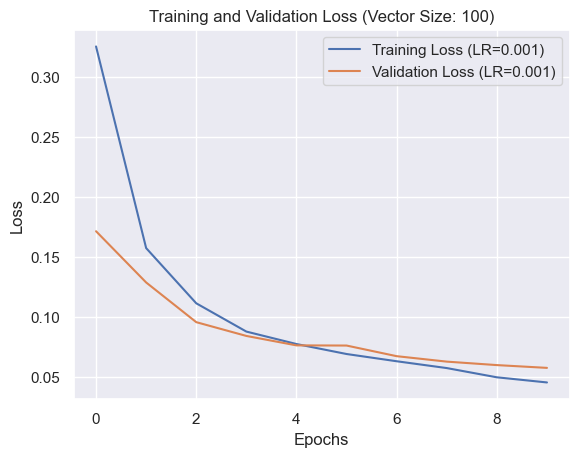

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.80      0.85      0.82       310
      Discovery       1.00      0.99      1.00      4096
      Execution       0.93      0.88      0.91      1728
       Harmless       0.09      0.67      0.15         6
         Impact       0.00      0.00      0.00         0
          Other       0.33      1.00      0.50         3
    Persistence       0.99      0.98      0.98      3745

      micro avg       0.97      0.96      0.97      9888
      macro avg       0.59      0.77      0.62      9888
   weighted avg       0.98      0.96      0.97      9888
    samples avg       0.97      0.97      0.97      9888



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 100, Learning Rate: 0.01)...
Loss on test set: 0.06168142706155777
Accuracy on test set: 0.8455343842506409


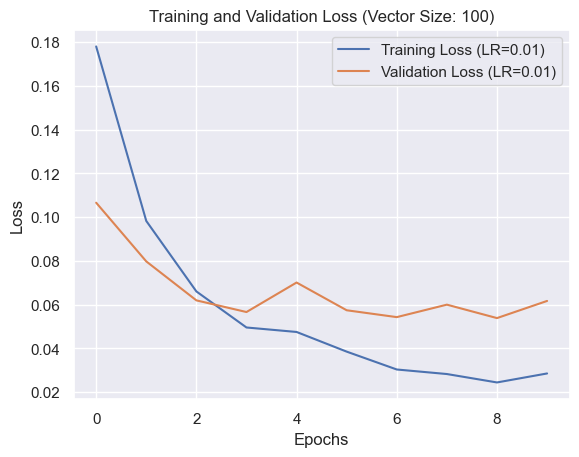

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.80      0.89      0.84       294
      Discovery       1.00      1.00      1.00      4075
      Execution       0.82      0.98      0.89      1371
       Harmless       0.48      0.55      0.51        40
         Impact       0.22      0.50      0.31         4
          Other       0.56      1.00      0.71         5
    Persistence       0.98      0.99      0.99      3688

      micro avg       0.95      0.99      0.97      9477
      macro avg       0.69      0.84      0.75      9477
   weighted avg       0.96      0.99      0.97      9477
    samples avg       0.96      0.98      0.97      9477

Training the model (Vector Size: 100, Learning Rate: 0.1)...


C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on test set: 0.12806454300880432
Accuracy on test set: 0.6215226650238037


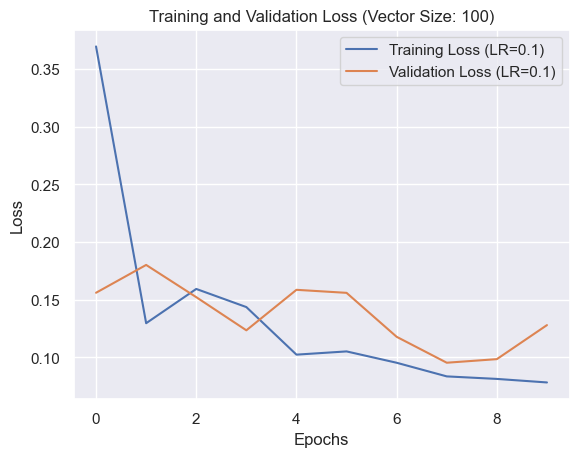

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.78      0.73      0.75       351
      Discovery       1.00      0.99      1.00      4094
      Execution       0.82      0.90      0.86      1486
       Harmless       0.00      0.00      0.00         0
         Impact       0.11      1.00      0.20         1
          Other       0.00      0.00      0.00         0
    Persistence       0.98      0.97      0.97      3747

      micro avg       0.95      0.96      0.95      9679
      macro avg       0.53      0.66      0.54      9679
   weighted avg       0.96      0.96      0.96      9679
    samples avg       0.95      0.96      0.95      9679



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.001)...
Loss on test set: 0.06808716058731079
Accuracy on test set: 0.8782333135604858


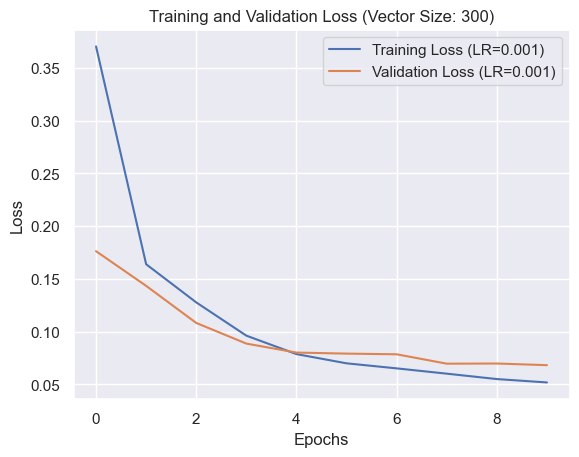

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.73      0.84      0.78       284
      Discovery       1.00      1.00      1.00      4086
      Execution       0.93      0.84      0.88      1793
       Harmless       0.02      1.00      0.04         1
         Impact       0.00      0.00      0.00         0
          Other       0.33      1.00      0.50         3
    Persistence       0.99      0.98      0.98      3759

      micro avg       0.97      0.96      0.96      9926
      macro avg       0.57      0.81      0.60      9926
   weighted avg       0.97      0.96      0.96      9926
    samples avg       0.97      0.96      0.96      9926



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.01)...
Loss on test set: 0.06470678746700287
Accuracy on test set: 0.8716446757316589


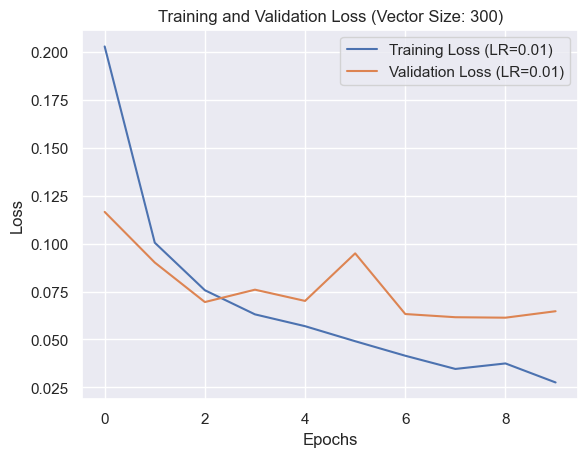

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.79      0.90      0.84       287
      Discovery       1.00      1.00      1.00      4078
      Execution       0.92      0.90      0.91      1673
       Harmless       0.07      0.43      0.11         7
         Impact       0.00      0.00      0.00         0
          Other       0.56      1.00      0.71         5
    Persistence       0.99      0.98      0.99      3728

      micro avg       0.97      0.97      0.97      9778
      macro avg       0.62      0.74      0.65      9778
   weighted avg       0.97      0.97      0.97      9778
    samples avg       0.97      0.97      0.97      9778



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.1)...
Loss on test set: 0.09565114229917526
Accuracy on test set: 0.8399218916893005


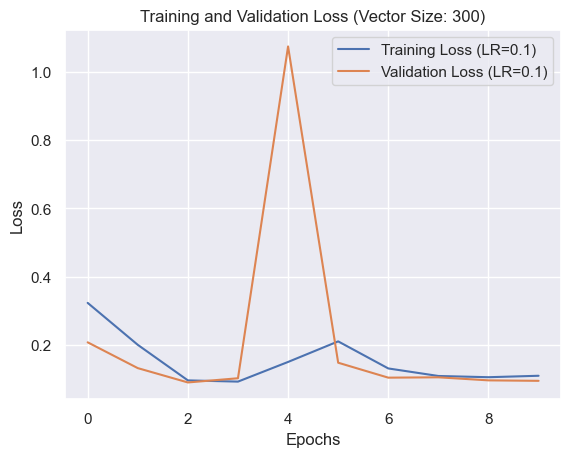

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.47      0.91      0.62       170
      Discovery       1.00      0.99      1.00      4098
      Execution       0.74      0.92      0.82      1316
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.94      0.97      3926

      micro avg       0.93      0.96      0.95      9510
      macro avg       0.46      0.54      0.49      9510
   weighted avg       0.95      0.96      0.95      9510
    samples avg       0.94      0.96      0.94      9510



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.001)...
Loss on test set: 0.06647802889347076
Accuracy on test set: 0.8721327185630798


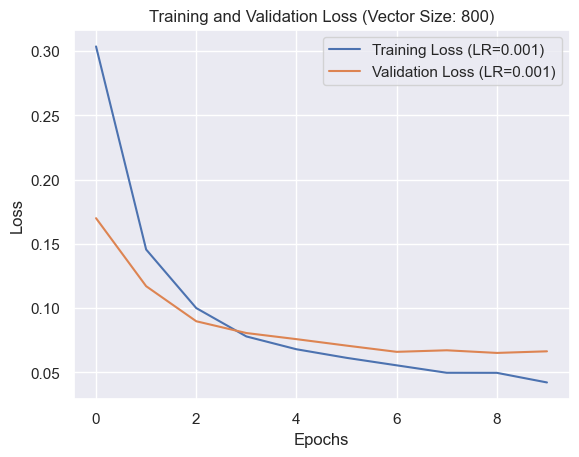

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.78      0.84      0.81       307
      Discovery       1.00      1.00      1.00      4089
      Execution       0.82      0.94      0.88      1426
       Harmless       0.04      0.67      0.08         3
         Impact       0.00      0.00      0.00         0
          Other       0.44      1.00      0.62         4
    Persistence       0.99      0.98      0.98      3745

      micro avg       0.95      0.98      0.96      9574
      macro avg       0.58      0.77      0.62      9574
   weighted avg       0.96      0.98      0.97      9574
    samples avg       0.96      0.97      0.96      9574



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.01)...
Loss on test set: 0.06216741353273392
Accuracy on test set: 0.9099560976028442


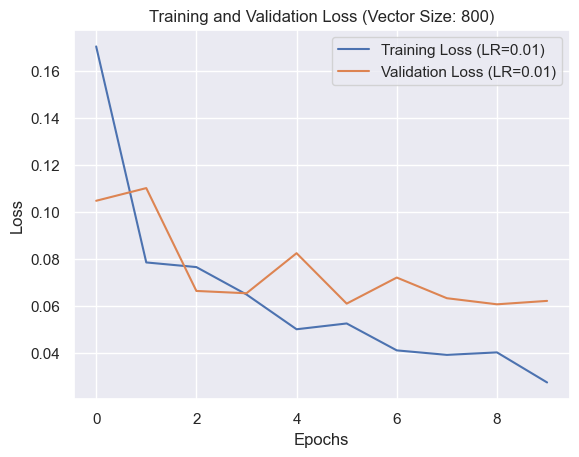

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.74      0.91      0.81       265
      Discovery       1.00      1.00      1.00      4084
      Execution       0.85      0.96      0.90      1445
       Harmless       0.48      0.49      0.48        45
         Impact       0.00      0.00      0.00         0
          Other       0.78      0.78      0.78         9
    Persistence       0.99      0.98      0.99      3735

      micro avg       0.96      0.98      0.97      9583
      macro avg       0.69      0.73      0.71      9583
   weighted avg       0.96      0.98      0.97      9583
    samples avg       0.96      0.98      0.97      9583



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.1)...
Loss on test set: 0.09864264726638794
Accuracy on test set: 0.9148365259170532


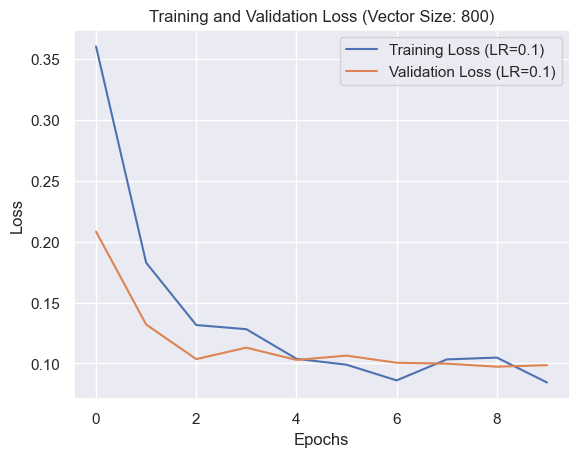

129/129 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.65      0.85      0.74       250
      Discovery       1.00      0.99      1.00      4098
      Execution       0.78      0.88      0.83      1451
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       0.99      0.96      0.98      3849

      micro avg       0.94      0.96      0.95      9648
      macro avg       0.49      0.53      0.51      9648
   weighted avg       0.96      0.96      0.96      9648
    samples avg       0.95      0.96      0.95      9648



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
# Loop over each vector size
for vector_size in vector_sizes:
    X, y, doc2vec_model = train_doc2vec_model(df_sampled, vector_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Loop over each learning rate
    for learning_rate in learning_rates:
        train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs)


In [88]:
"""# Plotting additional metrics for each model
sns.set_theme(style="darkgrid")
for vector_histories in all_histories:  # Iterate over lists of histories for each vector size
    for history in vector_histories:  # Iterate over individual history dictionaries for each learning rate
        print("Keys in history:", history.keys())  # Print keys of history dictionary
        plt.figure(figsize=(12, 6))

        plt.suptitle(f"Model Training Metrics")

        plt.subplot(2, 2, 1)
        plt.plot(history["loss"], label='Training Loss')
        plt.plot(history["val_loss"], label='Validation Loss')
        plt.title("Training and Validation Loss")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(history["auc"], label="Training AUC")
        plt.plot(history["val_auc"], label="Validation AUC")
        plt.title("Training and Validation AUC")
        plt.ylabel("AUC")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(history["precision"], label="Training Precision")
        plt.plot(history["val_precision"], label="Validation Precision")
        plt.title("Training and Validation Precision")
        plt.ylabel("Precision")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(history["recall"], label="Training Recall")
        plt.plot(history["val_recall"], label="Validation Recall")
        plt.title("Training and Validation Recall")
        plt.ylabel("Recall")
        plt.legend()

        plt.tight_layout()
        plt.show()"""

'# Plotting additional metrics for each model\nsns.set_theme(style="darkgrid")\nfor vector_histories in all_histories:  # Iterate over lists of histories for each vector size\n    for history in vector_histories:  # Iterate over individual history dictionaries for each learning rate\n        print("Keys in history:", history.keys())  # Print keys of history dictionary\n        plt.figure(figsize=(12, 6))\n\n        plt.suptitle(f"Model Training Metrics")\n\n        plt.subplot(2, 2, 1)\n        plt.plot(history["loss"], label=\'Training Loss\')\n        plt.plot(history["val_loss"], label=\'Validation Loss\')\n        plt.title("Training and Validation Loss")\n        plt.ylabel("Loss")\n        plt.legend()\n\n        plt.subplot(2, 2, 2)\n        plt.plot(history["auc"], label="Training AUC")\n        plt.plot(history["val_auc"], label="Validation AUC")\n        plt.title("Training and Validation AUC")\n        plt.ylabel("AUC")\n        plt.legend()\n\n        plt.subplot(2, 2, 3)\n

# FINE EXTRA

# FINE TEST

In [52]:
'''sns.set_theme(style="darkgrid")
for result in results:
    plt.figure(figsize=(12, 6))

    print(result.get("metrics").history)
    plt.suptitle(f"learning rate: {result.get('learning_rate')}")

    plt.subplot(2, 2, 1)
    plt.plot(result.get("metrics").history["loss"], label='Training Loss')
    plt.plot(result.get("metrics").history["val_loss"], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(result.get("metrics").history["auc"], label="Training AUC")
    plt.plot(result.get("metrics").history["val_auc"], label="Validation AUC")
    plt.title("Training and Validation AUC")
    plt.ylabel("AUC")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(result.get("metrics").history["precision"], label="Training Precision")
    plt.plot(result.get("metrics").history["val_precision"], label="Validation Precision")
    plt.title("Training and Validation Precision")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(result.get("metrics").history["recall"], label="Training Recall")
    plt.plot(result.get("metrics").history["val_recall"], label="Validation Recall")
    plt.title("Training and Validation Recall")
    plt.ylabel("Recall")
    plt.legend()


    plt.tight_layout()
    plt.show()'''

'sns.set_theme(style="darkgrid")\nfor result in results:\n    plt.figure(figsize=(12, 6))\n\n    print(result.get("metrics").history)\n    plt.suptitle(f"learning rate: {result.get(\'learning_rate\')}")\n\n    plt.subplot(2, 2, 1)\n    plt.plot(result.get("metrics").history["loss"], label=\'Training Loss\')\n    plt.plot(result.get("metrics").history["val_loss"], label=\'Validation Loss\')\n    plt.title("Training and Validation Loss")\n    plt.ylabel("Loss")\n    plt.legend()\n\n    plt.subplot(2, 2, 2)\n    plt.plot(result.get("metrics").history["auc"], label="Training AUC")\n    plt.plot(result.get("metrics").history["val_auc"], label="Validation AUC")\n    plt.title("Training and Validation AUC")\n    plt.ylabel("AUC")\n    plt.legend()\n\n    plt.subplot(2, 2, 3)\n    plt.plot(result.get("metrics").history["precision"], label="Training Precision")\n    plt.plot(result.get("metrics").history["val_precision"], label="Validation Precision")\n    plt.title("Training and Validation Pre

Results for Learning Rate: 0.1, Epochs: 5
Training Metrics:
The initial 5 epochs show significant improvements in various metrics. The loss decreases, and AUC, precision, and recall all exhibit positive trends. These improvements indicate that the model is learning from the data and adapting its parameters to better fit the training set.

Validation Metrics:
Validation metrics also show promising results after 5 epochs. The decreasing validation loss and improving AUC, precision, and recall suggest that the model generalizes well to unseen data.

Results for Learning Rate: 0.1, Epochs: 10
Training Metrics:
Extending training to 10 epochs results in continued improvements, albeit at a slower rate. The loss, AUC, precision, and recall all show positive trajectories, indicating ongoing refinement of the model.

Validation Metrics:
Validation metrics maintain consistency with training metrics, showcasing that the model's performance extends beyond the training set. The decreasing validation loss and improvements in AUC, precision, and recall suggest that the model is still benefiting from additional training.

Results for Learning Rate: 0.1, Epochs: 15
Training Metrics:
Training for 15 epochs demonstrates marginal improvements in metrics. The loss continues to decrease, but AUC, precision, and recall show slower rates of improvement, indicating potential diminishing returns.

Validation Metrics:
Validation metrics exhibit similar trends, with diminishing returns after 10 epochs. While the model continues to generalize, the rate of improvement decreases.

Discussion on Sufficient Epochs:
The observed trends suggest that the model achieves significant gains within the initial 5 to 10 epochs. Beyond this point, the rate of improvement diminishes, indicating that additional epochs may offer limited benefits. This phenomenon is often referred to as "early stopping," where training is halted once the model's performance plateaus, preventing overfitting.

Considering computational efficiency and avoiding overfitting, it seems reasonable to stop training around 10 epochs. This allows the model to capture the underlying patterns in the data without unnecessary computational costs.

6 Epochs: Stopping at 6 epochs appears to capture substantial improvements in the model. The trends indicate that the model is learning effectively, and additional epochs may provide diminishing returns.

10 Epochs: Extending training to 10 epochs could lead to further refinement, particularly in fine-tuning the model's parameters. However, this comes with increased computational cost.

Stopping at 6 epochs seems to strike a balance between efficiency and model performance

Comparison with Learning Rate: 0.1
Learning Rate: 0.01 vs. 0.1
Loss: The model with a learning rate of 0.01 generally achieves lower training and validation losses, indicating better convergence.
AUC: Both learning rates show similar positive trends in AUC, but 0.01 may provide slightly better discrimination ability.
Precision and Recall: Both learning rates lead to improved precision and recall, but 0.01 appears to offer slightly better performance.

The learning rate of 0.001 demonstrates effective learning, showing superior convergence and performance across key metrics compared to 0.01 and 0.1.
While both 0.01 and 0.1 show reasonable performance, 0.001 is a promising candidate for further experimentation and fine-tuning to optimize model performance.

In [53]:
'''def print_results_for_lr_and_epochs(learning_rate, epochs, results):
    print(f"\nResults for Learning Rate: {learning_rate}, Epochs: {epochs}\n")
    
    # Filter results for the specified learning rate and epochs
    lr_epochs_results = [result for result in results if result["learning_rate"] == learning_rate and result["epochs"] == epochs]

    for result in lr_epochs_results:
        # Print the metrics from history
        print("Training Metrics:")
        for metric_name, values in result["metrics"].history.items():
            print(f"{metric_name}: {values}")

        # Print validation metrics
        print("Validation Metrics:")
        for metric_name, values in result["metrics"].history.items():
            print(f"val_{metric_name}: {values}")'''

'def print_results_for_lr_and_epochs(learning_rate, epochs, results):\n    print(f"\nResults for Learning Rate: {learning_rate}, Epochs: {epochs}\n")\n    \n    # Filter results for the specified learning rate and epochs\n    lr_epochs_results = [result for result in results if result["learning_rate"] == learning_rate and result["epochs"] == epochs]\n\n    for result in lr_epochs_results:\n        # Print the metrics from history\n        print("Training Metrics:")\n        for metric_name, values in result["metrics"].history.items():\n            print(f"{metric_name}: {values}")\n\n        # Print validation metrics\n        print("Validation Metrics:")\n        for metric_name, values in result["metrics"].history.items():\n            print(f"val_{metric_name}: {values}")'

In [54]:
'''y_train_predictions = (model.predict(X_train_tensor) > 0.5).astype("int32")
y_test_predictions = (model.predict(X_test_tensor) > 0.5).astype("int32")'''

'y_train_predictions = (model.predict(X_train_tensor) > 0.5).astype("int32")\ny_test_predictions = (model.predict(X_test_tensor) > 0.5).astype("int32")'

In [55]:
'''report_train = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True)
df_report_train = pd.DataFrame(report_train).transpose()
df_report_train'''

'report_train = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True)\ndf_report_train = pd.DataFrame(report_train).transpose()\ndf_report_train'

In [56]:
'''report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test'''

'report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True)\ndf_report_test = pd.DataFrame(report_test).transpose()\ndf_report_test'

In [57]:
#loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(X_test_tensor, y_test_tensor)
'''loss_test, accuracy_test, precision_test, recall_test = model.evaluate(X_test_tensor, y_test_tensor)'''

'loss_test, accuracy_test, precision_test, recall_test = model.evaluate(X_test_tensor, y_test_tensor)'

In [58]:
'''print_results_for_lr_and_epochs(0.001, 5, results)'''

'print_results_for_lr_and_epochs(0.001, 5, results)'

In [59]:
'''print_results_for_lr_and_epochs(0.001, 10, results)'''

'print_results_for_lr_and_epochs(0.001, 10, results)'

In [60]:
'''print_results_for_lr_and_epochs(0.001, 15, results)'''

'print_results_for_lr_and_epochs(0.001, 15, results)'

In [61]:
'''results[0].get("metrics").history'''

'results[0].get("metrics").history'